In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import h5py
import sunpy 
import sunpy.map
from sharpesst.correct_2d_psf import get_fwd_matrices, correct_spice_raster
from sharpesst.util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from sharpesst.fit_spice_lines import get_overall_center, fit_spice_lines as fsl
import astropy
from astropy.visualization import (ImageNormalize, AsinhStretch)
from astropy import constants as const
import astropy.units as u
from astropy.wcs import WCS
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFit2D

from copy import deepcopy

In [2]:
spice_raster = read_spice_l2_fits("../src/solo_L2_spice-n-ras_20221020T231536_V06_150995364-000.fits")

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59872.969168 from DATE-OBS.
Set MJD-BEG to 59872.969168 from DATE-BEG.
Set MJD-AVG to 59873.047270 from DATE-AVG.
Set MJD-END to 59873.125369 from DATE-END'. [astropy.wcs.wcs]


In [3]:
spice_raster.keys()

dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'N III 991 (Merged)'])

In [4]:
spice_NeVIII_770_window = spice_raster["Ne VIII 770 - Peak"]

In [5]:
spice_NeVIII_770_window.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'WAVE' 'TIME' 
CRVAL : -0.11831583088916667 0.1581017717011111 7.699282680000001e-08 6747.875 
CRPIX : 112.5 416.5 25.5 1.0 
PC1_1 PC1_2 PC1_3 PC1_4  : 0.993437010613 -0.0313974558467 0.0 0.0 
PC2_1 PC2_2 PC2_3 PC2_4  : 0.416686817186 0.993437010613 0.0 0.0 
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0 0.0 1.0 0.0 
PC4_1 PC4_2 PC4_3 PC4_4  : -60.25 0.0 0.0 1.0 
CDELT : 0.0011111111111111111 0.00030500000000000004 9.751700000000001e-12 1.0 
NAXIS : 224  832  50  1

In [6]:
spice_NeVIII_770_window.data.shape

(1, 50, 832, 224)

In [7]:
NeVIII_770_window_rebin = spice_NeVIII_770_window.rebin((1,50,1,1))[0,0,:,:]

In [8]:
NeVIII_770_window_int_map = sunpy.map.Map(NeVIII_770_window_rebin.data, NeVIII_770_window_rebin.meta)

In [9]:
NeVIII_770_window_int_map.plot_settings['cmap'] = 'sohoeit171'
NeVIII_770_window_int_map.plot_settings['aspect'] = NeVIII_770_window_int_map.scale.axis2/NeVIII_770_window_int_map.scale.axis1
NeVIII_770_window_int_map.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.005))

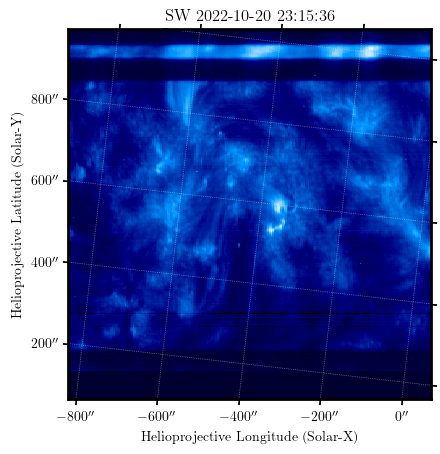

In [10]:
NeVIII_770_window_int_map.plot()

In [11]:
spice_dat = deepcopy(spice_NeVIII_770_window.data[0])
specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)
spice_dat = spice_dat - specmin[:,:,np.newaxis]
# spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,33:40],:,:], axis=0)[np.newaxis,:,:]

/tmp/ipykernel_562006/2103534116.py:2: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_NeVIII_770_window.data[0], axis=2)


In [12]:
spice_dat.shape

(50, 832, 224)

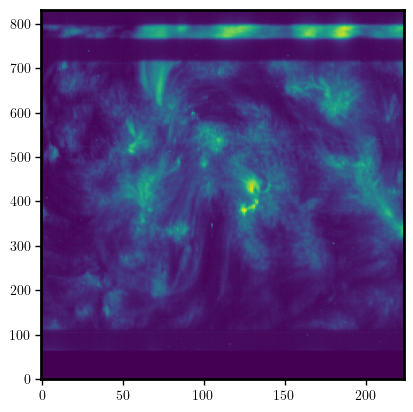

In [15]:
plt.imshow(np.nansum(spice_dat, axis=0)[:,:],origin="lower",norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.1)),
           aspect=1.098/4)

In [16]:
spice_hdr = spice_NeVIII_770_window.meta.original_header
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.5

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -15*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([2, 0.95])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([10.0, 2.5]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.2



In [17]:
spice_hdr["NBIN1"], spice_hdr["NBIN2"], spice_hdr["NBIN3"]

(1, 1, 1)

In [18]:
rebin_facs = [1,2,1]

In [19]:
spice_dat.shape

(50, 832, 224)

In [20]:
spicedat_bindown = bindown(spice_dat[:,120:700,:],np.round(np.array(spice_dat[:,120:700,:].shape)/rebin_facs).astype(np.int32))
spicedat_bindown.shape

(50, 290, 224)

In [21]:
NeVIII_770_window_int_map.data.shape

(832, 224)

In [22]:
NeVIII_770_window_int_map_crop = NeVIII_770_window_int_map.submap([0,120]*u.pix,top_right=[224,699]*u.pix) 

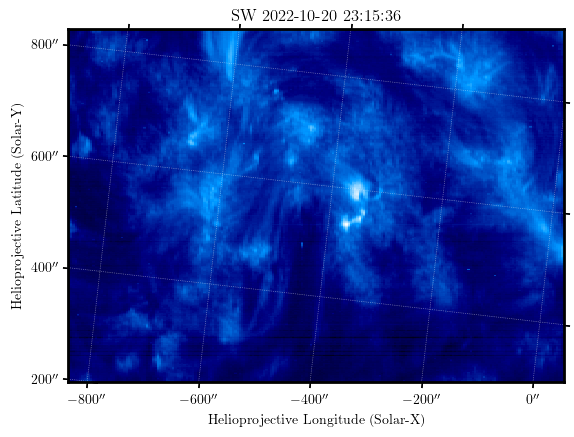

In [23]:
NeVIII_770_window_int_map_crop.plot()

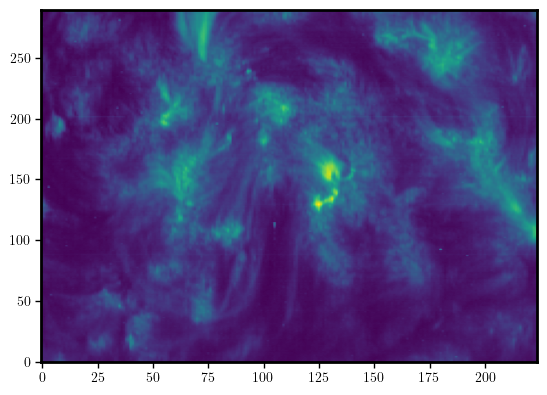

In [24]:
plt.imshow(np.nansum(spicedat_bindown, axis=0)[:,:],origin="lower",norm=ImageNormalize(stretch=AsinhStretch(0.1)),
              aspect=1.098*rebin_facs[1]/4)

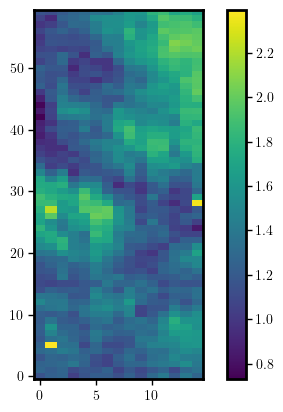

In [25]:
plt.imshow((np.nansum(spicedat_bindown[:,90:150,10:25], axis=0)**(1./2.2)),origin="lower",aspect=1.098*rebin_facs[1]/4)
plt.colorbar()

In [26]:
spice_err_fac = np.nanstd(spicedat_bindown[:,180:300,10:25])

In [27]:
# spicedat_bindown = spicedat_bindown - np.nanmedian(spicedat_bindown[:,125:175,0:25])

In [28]:
spice_dat1 = deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)

In [29]:
spice_dat1.shape

(224, 290, 50)

In [30]:
NeVIII_deconv_data_rebin_center = deepcopy(NeVIII_770_window_int_map_crop.center)
NeVIII_deconv_data_rebin_scale = u.Quantity((NeVIII_770_window_int_map_crop.scale.axis1,NeVIII_770_window_int_map_crop.scale.axis2*rebin_facs[1]))
NeVIII_deconv_data_rebin_rmatrix = deepcopy(NeVIII_770_window_int_map_crop.rotation_matrix)
NeVIII_deconv_data_rebin_rmatrix[0,1] = NeVIII_deconv_data_rebin_rmatrix[0,1]*rebin_facs[1]
NeVIII_deconv_data_rebin_rmatrix[1,0] = NeVIII_deconv_data_rebin_rmatrix[1,0]/rebin_facs[1]

NeVIII_deconv_data_rebin_header = sunpy.map.make_fitswcs_header(spice_dat1[:,:,0].T.shape,
                                                      NeVIII_deconv_data_rebin_center,
                                                        scale=NeVIII_deconv_data_rebin_scale,
                                                        rotation_matrix=NeVIII_deconv_data_rebin_rmatrix,
                                                        instrument="SPICE",
                                                        observatory="Solar Oribter",)
NeVIII_deconv_data_rebin_wcs = WCS(NeVIII_deconv_data_rebin_header)


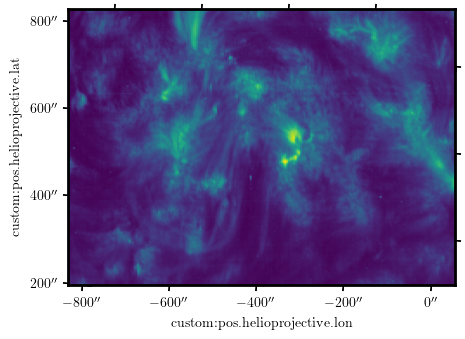

In [31]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection=NeVIII_deconv_data_rebin_wcs)
ax.imshow(np.nansum(spice_dat1,axis=2).T,origin="lower",norm=ImageNormalize(stretch=AsinhStretch(0.1)),
          aspect=1.098*rebin_facs[1]/4)

In [32]:
spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight,
                                                                    yl_core_xpo=yl_core_xpo,super_fac=1,chi2_th=0.5, 
                                                                    psf_thold_core=0.0005, spice_bin_facs=rebin_facs,)

Correcting Ne VIII 770 - Peak; ref. wavelength=767.4415845
Computing PSF Core:
4.993447823987861 % done after 1.2381784915924072 seconds
9.993792675356922 % done after 2.459768772125244 seconds
14.99413752672598 % done after 3.6892693042755127 seconds
19.99448237809504 % done after 4.916515111923218 seconds
24.9948272294641 % done after 6.237032175064087 seconds
29.99517208083316 % done after 7.482973337173462 seconds
34.99551693220222 % done after 8.70667552947998 seconds
39.99586178357128 % done after 9.81456184387207 seconds
44.99620663494034 % done after 10.919178247451782 seconds
49.9965514863094 % done after 11.998238325119019 seconds
54.99689633767846 % done after 13.067023515701294 seconds
59.99724118904752 % done after 14.111247062683105 seconds
64.99758604041658 % done after 15.59511137008667 seconds
69.99793089178564 % done after 16.63225293159485 seconds
74.99827574315471 % done after 17.701945781707764 seconds
79.99862059452376 % done after 18.774502992630005 seconds
84.99

In [33]:
spice_sdev_guess = 0.1
corr_sdev_guess = 0.05


spice_mask, spice_err = get_mask_errs(spice_dat1.astype(np.float64), spice_err_fac)
spice_corr_mask, spice_corr_err = get_mask_errs(spice_corr_dat, spice_err_fac)

[det_origin0, det_dims0, det_scale0] = metadict["det_origin0"], metadict["det_dims0"], metadict["det_scale0"]
spice_la = spice_NeVIII_770_window.spectral_axis.to_value("Angstrom")
spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]

/tmp/ipykernel_562006/844281563.py:10: RuntimeWarning: Mean of empty slice
  spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]


In [34]:
spice_fits = fsl(spice_dat1, spice_err, spice_la, spice_mask, spice_wlcen0, spice_sdev_guess)

spice_corr_fits = fsl(spice_corr_dat, spice_corr_err, spice_la, spice_corr_mask, spice_wlcen0, corr_sdev_guess)

0 of 224 0.0
11 of 224 0.0
22 of 224 0.0
33 of 224 0.0
44 of 224 0.0
55 of 224 0.0
66 of 224 0.0
77 of 224 0.0
88 of 224 0.0
99 of 224 0.0
110 of 224 0.0
121 of 224 0.0
132 of 224 0.0
143 of 224 0.0
154 of 224 0.0
165 of 224 0.0
176 of 224 0.0
187 of 224 0.0
198 of 224 0.0
209 of 224 0.0
220 of 224 0.0
223 of 224 0.0
0 of 224 0.0
11 of 224 0.0
22 of 224 0.0
33 of 224 0.0
44 of 224 0.0
55 of 224 0.0
66 of 224 0.0
77 of 224 0.0
88 of 224 0.0
99 of 224 0.0
110 of 224 0.0
121 of 224 0.0
132 of 224 0.0
143 of 224 0.0
154 of 224 0.0
165 of 224 0.0
176 of 224 0.0
187 of 224 0.0
198 of 224 0.0
209 of 224 0.0
220 of 224 0.0
223 of 224 0.0


In [35]:
spice_origin_vel = (spice_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_origin_vel = spice_origin_vel - np.nanmedian(spice_origin_vel[:,:])

spice_corr_vel = (spice_corr_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_corr_vel = spice_corr_vel - np.nanmedian(spice_corr_vel[:,:])

Text(0.5, 1.0, 'Corrected')

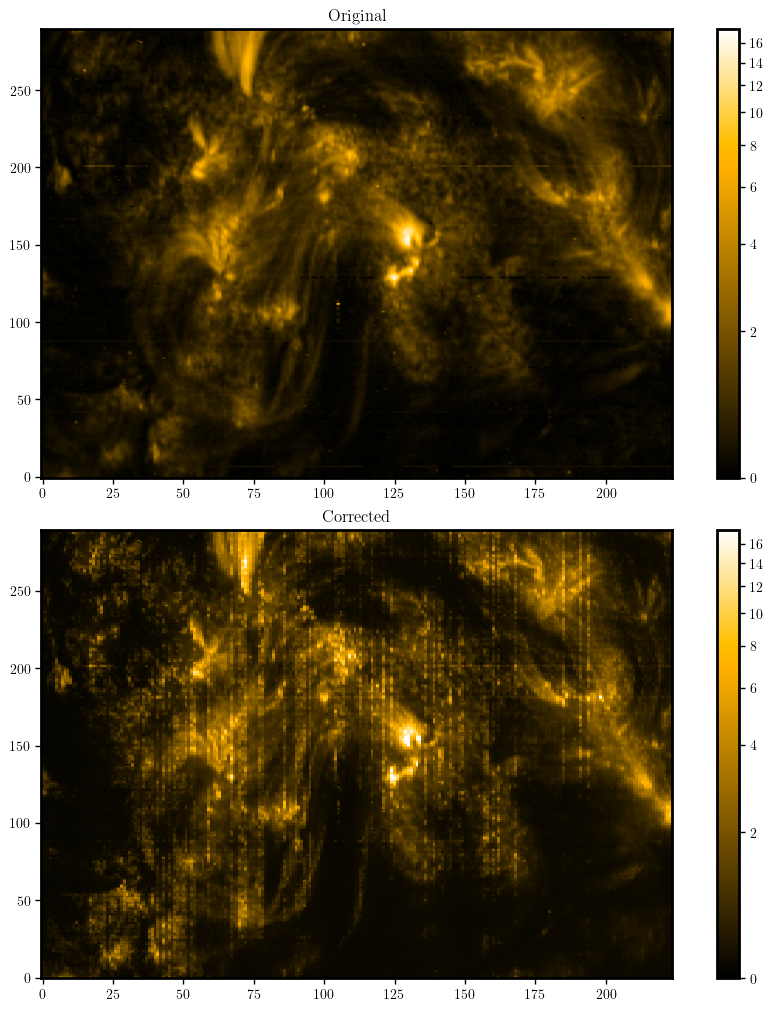

In [36]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

int_norm = ImageNormalize(stretch=AsinhStretch(0.1))

ax1.imshow(spice_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1.098*rebin_facs[1]/4,
           cmap="sdoaia171")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1.098*rebin_facs[1]/4,
              cmap="sdoaia171",interpolation="nearest")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")


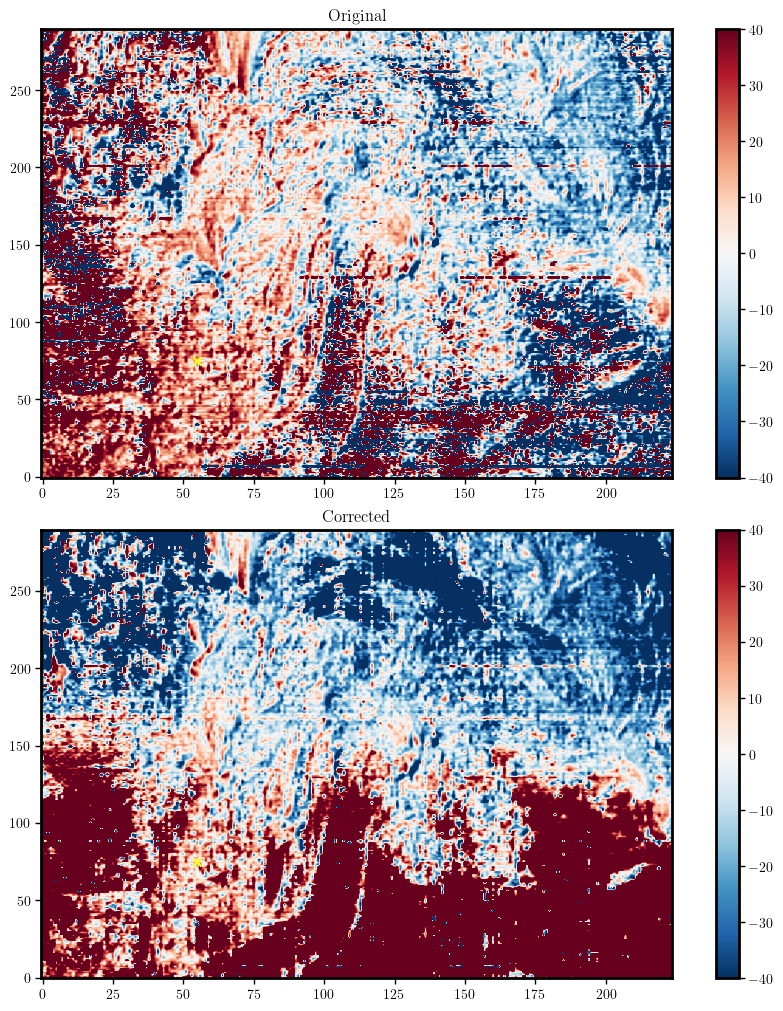

In [37]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

ax1.imshow(spice_origin_vel,origin="lower",vmin=-40,vmax=40,aspect=1.098*rebin_facs[1]/4,
           cmap="RdBu_r")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_vel,origin="lower",vmin=-40,vmax=40,aspect=1.098*rebin_facs[1]/4,
                cmap="RdBu_r")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")

for ax_ in (ax1,ax2):
    ax_.scatter(55,75,color="yellow",marker="x")

In [38]:
NeVIII_770_window_wvl = spice_NeVIII_770_window.spectral_axis.to_value("Angstrom")
NeVIII_deconv_rebin_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,16:30].transpose([1,0,2]).astype(np.float32), NeVIII_770_window_wvl[16:30],
                                line_number=1,line_wvl_init=[770],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
NeVIII_deconv_rebin_fitmodel.run_lse_mp(prev_init=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:277: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(self.multi_gaussian_diff_width, self.wvl_tofit, self.data_tofit,
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used i

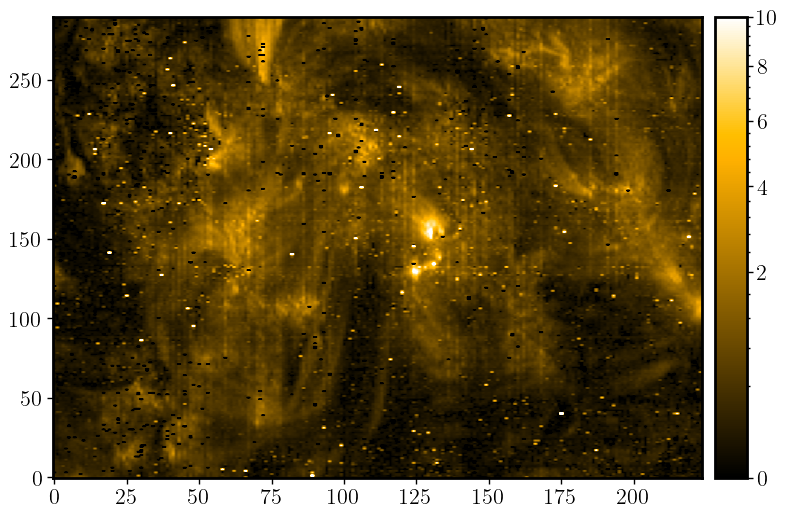

In [39]:
NeVIII_deconv_rebin_int = NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="int",vmin=0,vmax=10, scale="sqrt",
                                    aspect=1.098*rebin_facs[1]/4,cmap="sdoaia171",return_data=True)

Doppler velocity corrected by the median of the image.


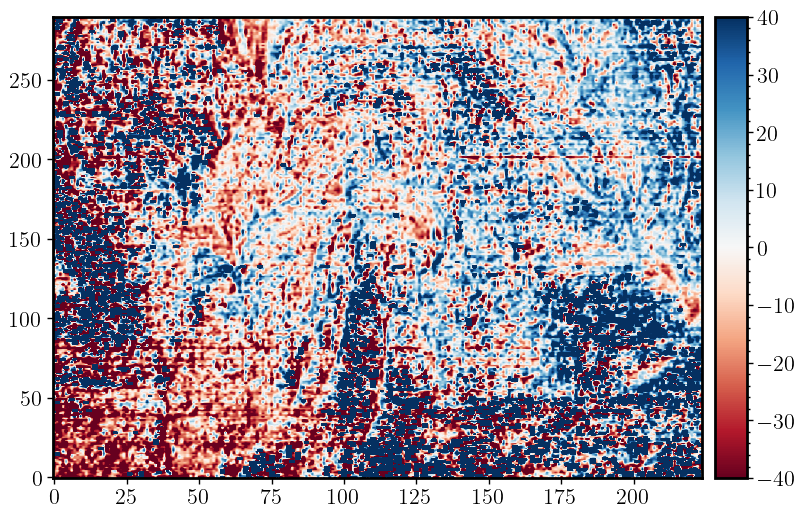

In [40]:
NeVIII_deconv_rebin_vel = NeVIII_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-40,vmax=40,vel_corr="image",ref_wvl=770.03,   
                                    aspect=1.098*rebin_facs[1]/4,cmap="RdBu",return_data=True)

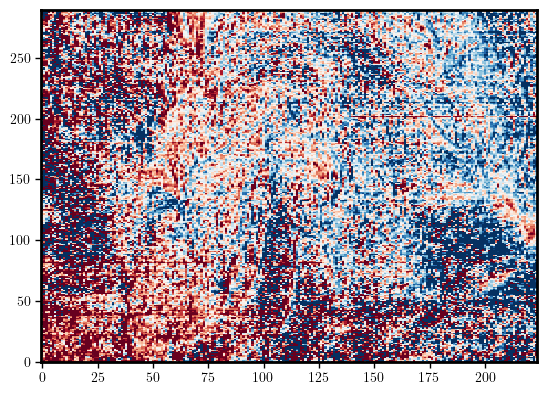

In [41]:
plt.imshow(NeVIII_deconv_rebin_vel,origin="lower",vmin=-40,vmax=40,aspect=1.098*rebin_facs[1]/4,
                cmap="RdBu",interpolation="none")

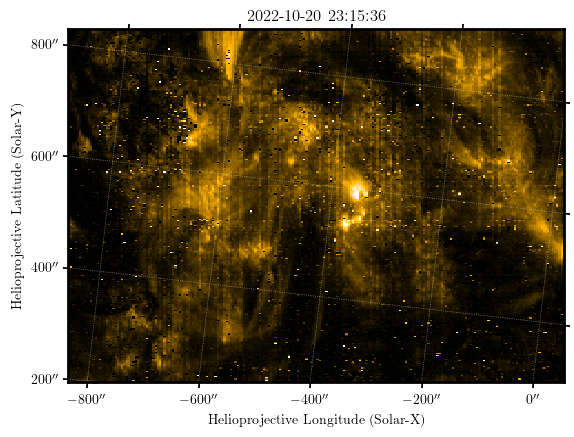

In [42]:
NeVIII_deconv_rebin_int_map = sunpy.map.Map(NeVIII_deconv_rebin_int, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_int_map.meta["rsun_ref"] = 696000000.0
NeVIII_deconv_rebin_int_map.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.1))
NeVIII_deconv_rebin_int_map.plot_settings['cmap'] = "sdoaia171"
NeVIII_deconv_rebin_int_map.plot_settings['aspect'] = NeVIII_deconv_rebin_int_map.scale.axis2/NeVIII_deconv_rebin_int_map.scale.axis1
NeVIII_deconv_rebin_int_map.plot()

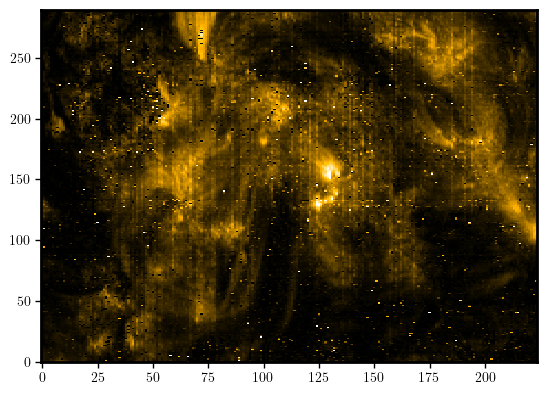

In [43]:
plt.imshow(NeVIII_deconv_rebin_int,origin="lower",norm=ImageNormalize(vmin=0,vmax=10,stretch=AsinhStretch(0.1)),aspect=1.098*rebin_facs[1]/4,
                cmap="sdoaia171",interpolation="none")

In [44]:
NeVIII_deconv_rebin_int_map.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_int_map.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_int_map.meta["ycore"], NeVIII_deconv_rebin_int_map.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_int_map.meta["ywing"], NeVIII_deconv_rebin_int_map.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_int_map.meta["wwgt"] = wing_weight
# NeVIII_deconv_rebin_int_map.save("../sav/sunpymaps/NeVIII_int_deconv_plowman2023_1020.fits",overwrite=True)

In [45]:
NeVIII_deconv_rebin_int_map_plowman = sunpy.map.Map(spice_corr_fits["amplitudes"].T, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_int_map_plowman.meta["rsun_ref"] = 696000000.0
NeVIII_deconv_rebin_int_map_plowman.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_int_map_plowman.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_int_map_plowman.meta["ycore"], NeVIII_deconv_rebin_int_map_plowman.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_int_map_plowman.meta["ywing"], NeVIII_deconv_rebin_int_map_plowman.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_int_map_plowman.meta["wwgt"] = wing_weight
# NeVIII_deconv_rebin_int_map_plowman.save("../sav/sunpymaps/NeVIII_int_deconv_plowman2023_1020_plowmanfit.fits",overwrite=True)

In [46]:
NeVIII_deconv_rebin_vel_map_plowman = sunpy.map.Map(spice_corr_vel, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_vel_map_plowman.meta["rsun_ref"] = 696000000.0
NeVIII_deconv_rebin_vel_map_plowman.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_vel_map_plowman.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_vel_map_plowman.meta["ycore"], NeVIII_deconv_rebin_vel_map_plowman.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_vel_map_plowman.meta["ywing"], NeVIII_deconv_rebin_vel_map_plowman.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_vel_map_plowman.meta["wwgt"] = wing_weight
# NeVIII_deconv_rebin_vel_map_plowman.save("../sav/sunpymaps/NeVIII_vel_deconv_plowman2023_1020_plowmanfit.fits",overwrite=True)

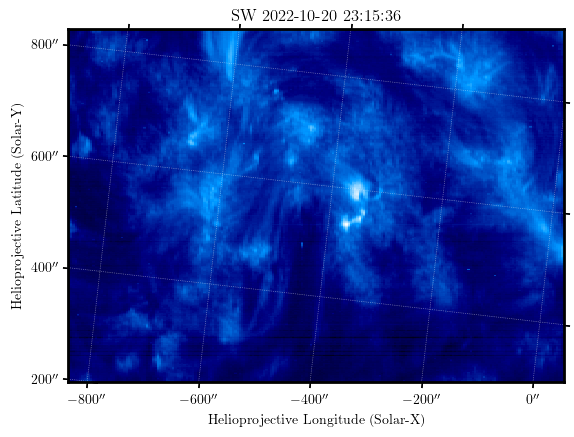

In [47]:
NeVIII_770_window_int_map_crop.plot()

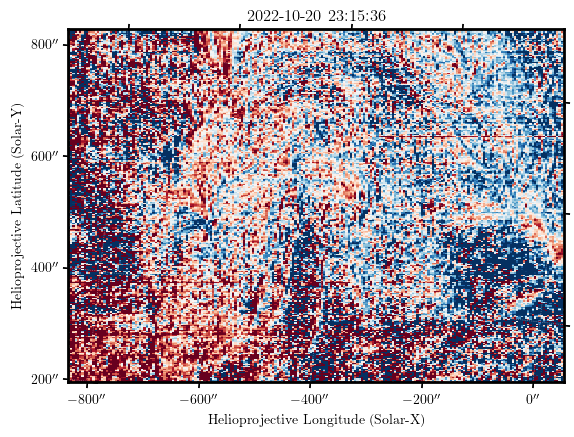

In [48]:
NeVIII_deconv_rebin_vel_map = sunpy.map.Map(-NeVIII_deconv_rebin_vel, NeVIII_deconv_data_rebin_wcs)
NeVIII_deconv_rebin_vel_map.meta["rsun_ref"] = 696000000.0
NeVIII_deconv_rebin_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-40,vmax=40)
NeVIII_deconv_rebin_vel_map.plot_settings["cmap"] = "RdBu_r"
NeVIII_deconv_rebin_vel_map.plot_settings["aspect"] = NeVIII_deconv_rebin_vel_map.scale.axis2/NeVIII_deconv_rebin_vel_map.scale.axis1
NeVIII_deconv_rebin_vel_map.plot()

In [49]:
NeVIII_deconv_rebin_vel_map.meta["ylxpo"] = yl_core_xpo
NeVIII_deconv_rebin_vel_map.meta["psfang"] = psf_yl_angle
NeVIII_deconv_rebin_vel_map.meta["ycore"], NeVIII_deconv_rebin_vel_map.meta["lcore"] = fwhm_core0_yl
NeVIII_deconv_rebin_vel_map.meta["ywing"], NeVIII_deconv_rebin_vel_map.meta["lwing"]  = fwhm_wing0_yl
NeVIII_deconv_rebin_vel_map.meta["wwgt"] = wing_weight
# NeVIII_deconv_rebin_vel_map.save("../sav/sunpymaps/NeVIII_vel_deconv_plowman2023_1020.fits",overwrite=True)

In [50]:
spice_corr_dat.shape

(224, 290, 50)

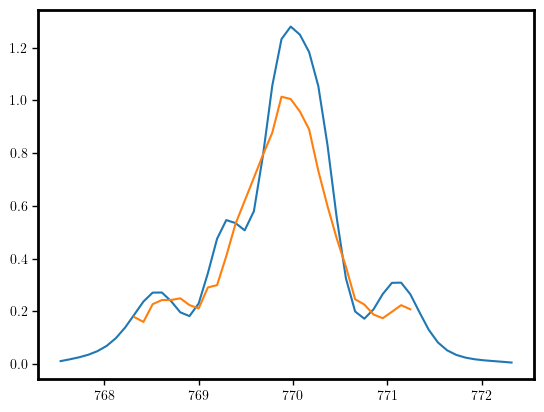

In [51]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[145,200,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[145,200,:])

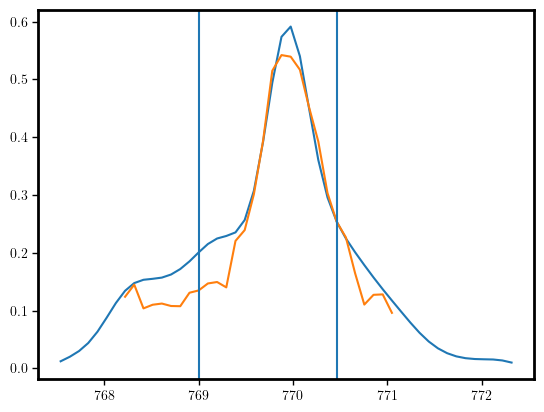

In [52]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[60,248,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[60,248,:])
plt.axvline(NeVIII_770_window_wvl[15])
plt.axvline(NeVIII_770_window_wvl[30])

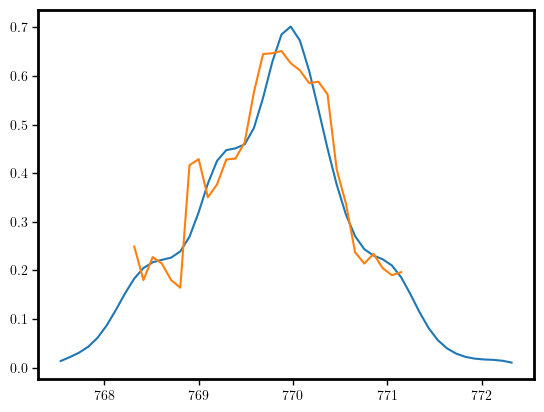

In [53]:
plt.plot(NeVIII_770_window_wvl, spice_corr_dat[75,220,:])
plt.plot(NeVIII_770_window_wvl, spice_dat1[75,220,:])

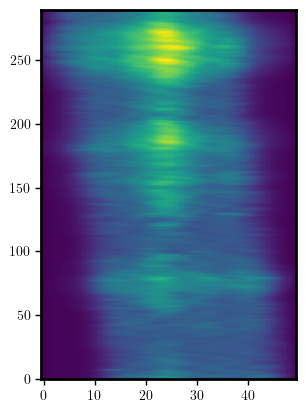

In [54]:
plt.imshow(spice_corr_dat[175,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))

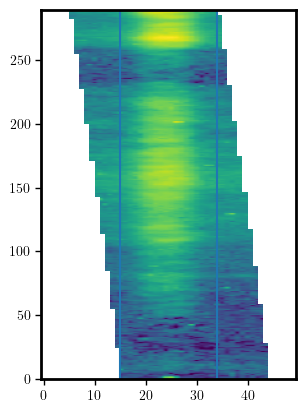

In [55]:
plt.imshow(spice_dat1[151,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))
plt.axvline(15)
plt.axvline(34)